In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
# Deep Learning
#import tensorflow as tf

In [2]:
def add_data_info():
    df1 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points-from-2017.csv', encoding= 'unicode_escape', low_memory=False)
    df2 = pd.read_csv('raw_data/charting-m-matches.csv', encoding= 'unicode_escape', low_memory=False)
    
    #get separated values from m-matches list of games - based on matchid
    df = pd.merge(df1,df2[['match_id','Date','Tournament','Round','Surface','Player 1','Player 2']], on=['match_id'], how='left')
    
    #add the condition of "Grand Slam" - 5 or 3 sets
    conditions = df['Tournament'].isin(["Wimbledon", "Australian Open", "US Open", "Roland Garros"])
    values = [1,0]

    # Create a new column  based on the conditions and values
    df['Grand Slam'] = pd.Series(pd.NA)
    df.loc[conditions, 'Grand Slam'] = values[0]
    df.loc[~conditions, 'Grand Slam'] = values[1]
    
    # save the original dataset with enriched data for future features
    df.to_csv('raw_data/charting-m-points-from-2017-enriched.csv', index=False)

In [3]:
def filter_player(df,opponent):
    
    # Read the dataset into a pandas DataFrame - from enriched file
    df = pd.read_csv(df, encoding= 'unicode_escape', low_memory=False)
    
    ## filtra pelo  oponente
    df = df[(df["Player 1"].str.contains(opponent)) | (df["Player 2"].str.contains(opponent))].copy()
    
    ##define se está sacando e se ganhou o ponto
    df['i_serve'] = np.where(((df['Svr'] == 1) & (df['Player 1'] == opponent )) | ((df['Svr'] == 2) & (df['Player 2'] == opponent)), 0, 1)
    df['i_win'] = np.where(((df['isSvrWinner'] == df['i_serve'])), 1, 0)
    df['is_second_service'] = np.where(((df['2nd'].isnull())), 0, 1)
    
    ## direção do saque
    # primeiro caractere do segundo saque
    df['dir_srv'] = df.loc[:, '2nd'].str[0]
    ## completa com o primeiro caractere do primeiro saque quando ele entrou
    df['dir_srv'].fillna(df.loc[:, '1st'].str[0], inplace=True)

    
    ##reseta o indice
    df.reset_index(inplace=True)
    
    ## salva arquivo e retorna dataset da funcao
    csv_file = "raw_data/" + opponent + "_points.csv"
    df.to_csv(csv_file, index=False)
    return df

In [4]:
meaning_char = pd.read_csv('https://raw.githubusercontent.com/eduardoscovino/tennis-analytics/master/code_map.csv',
                           encoding= 'unicode_escape', sep=';')

In [5]:
add_data_info()

In [6]:
df = filter_player('raw_data/charting-m-points-from-2017-enriched.csv','Novak Djokovic')

In [7]:
## serve direction encode 
df = df[df['dir_srv'].isin(['4','5','6'])]

## to numeric for rallyCount and serve direction
df['rallyCount']=pd.to_numeric(df['rallyCount'])
df['dir_srv']=pd.to_numeric(df['dir_srv'])

In [17]:
#Spliting Serve and Return
df['rally_desc'] = df.loc[:, '2nd']
df['rally_desc'].fillna(df.loc[:, '1st'], inplace=True)

##df['Serve'] = df.loc[:, 'rally_desc'].str[0:1]

df['rally_desc'] = df['rally_desc'].str[1:]

sc = np.array(meaning_char[~meaning_char['code'].isin(['f', 'b', 'r', 's', 'v', 'l', 'o', 'z', 'p', 'u', 'y', 'h', 'i', 'j', 'k','m', '1', '2', '3', '7', '8', '9'])]['code'])

#Spliting every shot
df['rally_desc'] = df['rally_desc'].apply(lambda x: ''.join([c for c in x if c not in sc]))
df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r').str.replace('v',' v').str.replace('l',' l').str.replace('o',' o').str.replace('z',' z').str.replace('p',' p').str.replace('u',' u').str.replace('y',' y').str.replace('h',' h').str.replace('i',' i').str.replace('j',' j').str.replace('k',' k').str.replace('m',' m')
df['rally_desc'] = df['rally_desc'].map(lambda x: x.lstrip(' ').rstrip(' '))

In [29]:
df['rally_desc'].map({'!':'','+':'','ˆ':'','C':'',';':''})

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
19319    NaN
19320    NaN
19321    NaN
19322    NaN
19323    NaN
Name: rally_desc, Length: 18751, dtype: object

In [18]:
df.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,serve_return
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,f18
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,f2
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,0,0,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,b3
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,1,0,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,r28


In [19]:
df['isUnforced'] = df['isUnforced'].replace({True: 1, False: 0})
df['isForced'] = df['isForced'].replace({True: 1, False: 0})
df['serve_return'] = df['rally_desc'].map(lambda x: x.split(' ')).str[0]

In [21]:
df['serve_return'].tail(50)


19272     b3
19273    f29
19274       
19275    b37
19276     s3
19277    b38
19278     f1
19279    s27
19280     s1
19281     s1
19282     f3
19283    f18
19284    b28
19285    f18
19286    f29
19287    b28
19288    b37
19289     s2
19290    r29
19291    r29
19292     f1
19293       
19294       
19295    f29
19297    f37
19298     b2
19299    f29
19300    f27
19301    f17
19302     f3
19303    f39
19304    b29
19305    b38
19306    b38
19307    f38
19308      f
19310       
19311     f3
19312    f28
19313    b29
19314     s3
19315    b37
19316    b18
19317     b1
19318    s18
19319    f38
19320    b39
19321    b39
19322    f19
19323    f39
Name: serve_return, dtype: object

## Dataset finalizado ##

In [30]:
df['serve_return'].nunique()

140

In [25]:
df['rally_desc'].nunique()

9835

In [ ]:
#df = df[df['serve_return']!=""]

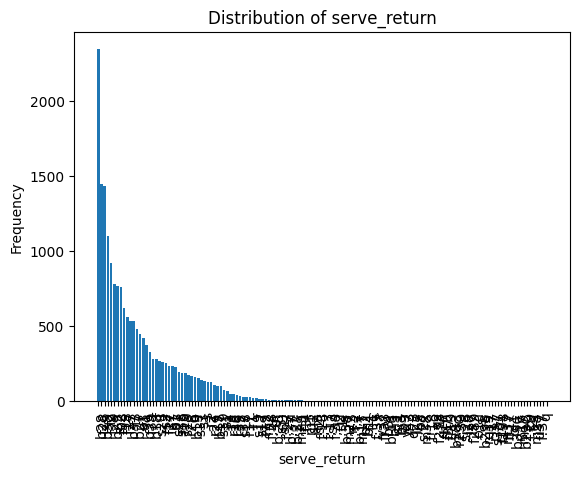

In [26]:
serve_return_column = df["serve_return"]
value_counts = serve_return_column.value_counts()

plt.bar(value_counts.index, value_counts.values )
plt.xlabel("serve_return")
plt.ylabel("Frequency")
plt.title("Distribution of serve_return")
plt.xticks(rotation=90)
plt.show()

In [28]:
serve_return_counts = df["serve_return"].value_counts().reset_index()
serve_return_counts.columns = ["serve_return", "frequency"]
serve_return_counts = serve_return_counts.sort_values("frequency", ascending=False )

serve_return_counts.tail(75)


,serve_return,frequency
65,f3!,6
68,m3,5
69,s2!,5
70,f;18,5
67,s!2,5
66,m1,5
71,;,4
72,f;17,4
73,s!3,4
74,f;38,4


In [ ]:
rally_count_dist = df["rallyCount"]
rally_count_dist = rally_count_dist.dropna()

plt.hist(serve_return_column)
plt.xlabel("rally_count_dist")
plt.ylabel("Frequency")
plt.title("Distribution of rally count")
plt.show()

In [ ]:
df[df['serve_return'] == 'f273m3']

In [ ]:
rally_counts = df["rallyCount"].value_counts().reset_index()
rally_counts.columns = ["rally_counts", "frequency"]
rally_counts = rally_counts.sort_values("frequency", ascending=False )

print(rally_counts)

## Geração das features

In [ ]:
features = ['Surface',
            'Round',
            'Grand Slam',
            'i_serve',
            'is_second_service',
            'dir_srv',
            'rallyCount',
            'isUnforced',
            'isForced',
            "serve_return"
            ]
X = df[features]
y = df['i_win']

In [ ]:
feat_categorical = ['Surface','Round','dir_srv','serve_return']

In [ ]:
X.info()

## separação - treino, teste e validação

In [ ]:
from sklearn.model_selection import train_test_split

# Train-Test Split - ## parametro stratify ###
train, test = train_test_split(df, test_size=0.3)

# Train-Val Split
train, val = train_test_split(train, test_size=0.3)


In [ ]:
## Separating features and target in the Train, Val and Test Set

X_train = train[features]
y_train = train['i_win']

X_val = val[features]
y_val = val['i_win']

X_test = test[features]
y_test = test['i_win']

In [ ]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

In [ ]:
X_train['serve_return'].nunique()

## Inicio do modelo - pre processamento e encoder

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display="diagram")

In [ ]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=["object"]))
)

preproc

In [ ]:
preproc.fit_transform(X_train).shape

In [ ]:
X_train_preproc = preproc.fit_transform(X_train)
X_val_preproc = preproc.transform(X_val)
X_test_preproc = preproc.transform(X_test)

## Definição do modelo

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

# 1. Architecture
model.add(layers.Dense(32, activation='relu', input_shape=(X_train_preproc.shape[-1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# 2. Compiling
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
# 3. Training
es = EarlyStopping(monitor = 'val_accuracy',
                   patience = 5,
                   verbose = 0,
                   restore_best_weights = True)

history = model.fit(X_train_preproc,
                   y_train,
                   validation_data = (X_val_preproc, y_val),
                   batch_size = 64,
                   epochs = 500,
                   callbacks = [es], 
                   verbose = 1)

## Resultado final / evaluate

In [ ]:
res = model.evaluate(X_test_preproc, y_test)
print(f"accuracy = {res[1]:.3f}")

In [ ]:
model.summary()

## Verificação loss/accuracy - overfit / underfit

In [ ]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

In [ ]:
plot_loss_accuracy(history)